In [41]:
from fastai.vision.all import *
import albumentations
import os

## Config

In [2]:
import os
# Check if running in a Kaggle environment
is_kaggle = False
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    is_kaggle = True
else:
    is_kaggle = False

is_kaggle

False

In [43]:
from pathlib import Path
Config = {
    'path': Path('./data') if not is_kaggle else Path('../input/paddy-disease-classification'), 
    'model1': 'convnext_small_in22k', 
    'bs': 64, 
    'seed': 42
}
Config['path']

Path('data')

## Data

### Define Augmentations

In [4]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
    
def get_train_aug(img_size): return albumentations.Compose([
            albumentations.RandomResizedCrop(img_size,img_size, scale=0.75),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
])

def get_valid_aug(img_size): return albumentations.Compose([
    albumentations.CenterCrop(img_size,img_size, p=1.),
    albumentations.Resize(img_size,img_size)
], p=1.)

## Training

### Try different models

In [37]:
def get_dls(img_size) -> DataLoader: 
    dls = ImageDataLoaders.from_folder(
        Config['path']/'train_images', 
        valid_pct=.2, 
        seed=Config['seed'],
        item_tfms=[Resize(img_size, method='squish')], 
        batch_tfms=[AlbumentationsTransform(get_train_aug(img_size))], 
        bs=Config['bs']
    )
    return dls

In [5]:
Config['model1']

'convnext_small_in22k'

In [6]:
def train(model, num_epochs=5, img_size = 64) -> Learner: 
    dls = ImageDataLoaders.from_folder(
        Config['path'], 
        valid_pct=0.2, 
        seed=Config['seed'],
        item_tfms=[Resize(img_size, method='squish')], 
        batch_tfms=[AlbumentationsTransform(get_train_aug(img_size))], 
        bs=Config['bs']
    )
    leaner = vision_learner(dls, model, metrics=error_rate)
    leaner.fine_tune(num_epochs, 0.01)
    return leaner

In [7]:
leaner1 = train(Config['model1'], img_size=64)

/Users/quankento/miniconda3/envs/torch/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.965731,1.645348,0.563964,02:17


epoch,train_loss,valid_loss,error_rate,time
0,1.443624,1.274292,0.474955,05:13
1,1.387455,1.207260,0.462703,05:10
2,1.232066,1.074164,0.412613,05:08
3,1.005592,0.955064,0.380180,05:09
4,0.876345,0.937102,0.359640,05:09


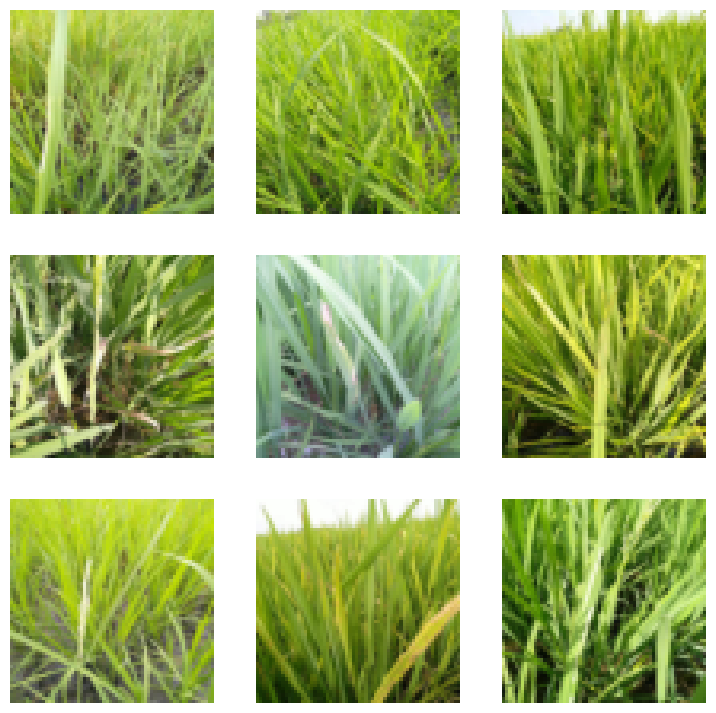

In [64]:
test_files = get_image_files(Config['path']/'test_images').sorted()
test_dls = leaner1.dls.test_dl(test_files)
test_dls.show_batch()

In [65]:
preds, idxs = leaner1.get_preds(dl=test_dls)

In [66]:
preds1, idxs1 = leaner1.tta(dl=test_dls)

: 

In [38]:
preds.shape

torch.Size([3469, 11])

In [44]:
Config['path']

Path('data')

In [57]:
vocab = leaner1.dls.vocab
vocab_dict = dict(enumerate(vocab))
vocab_dict

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'test_images',
 10: 'tungro'}

In [59]:
submission = preds1.argmax(dim=1)
submission

tensor([7, 8, 9,  ..., 8, 9, 5])

In [63]:
pd.DataFrame({
    'image_id': sorted(os.listdir(Config['path']/'test_images')), 
    'label': pd.Series(submission).map(vocab_dict)
}).to_csv('submission.csv', index=False)